In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import numpy as np
import pickle
import haversine as hs
from haversine import Unit


/tmp/ipykernel_577150/935555890.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
input_data_folder_base = Path("../results/")
input_data_folder = Path.cwd() / input_data_folder_base
overall_collection_file_name = "overall_collection_2023.p"
key_parameter_file_name = "key_parameter_2023.p"
print(f"Reading raw pandas files from \n    {input_data_folder}")

output_data_folder = input_data_folder
print(f"Writing merged pandas file to \n    {output_data_folder}")

Reading raw pandas files from 
    /home/sebastian/Nextcloud/Projekte/2021_DAAD_Brasilien/2023/RoBiMo_Trop_DataSet/notebooks/../results
Writing merged pandas file to 
    /home/sebastian/Nextcloud/Projekte/2021_DAAD_Brasilien/2023/RoBiMo_Trop_DataSet/notebooks/../results


In [3]:
df_results = pd.read_pickle(input_data_folder / overall_collection_file_name)
df_results.head(3)

,lat_est,lon_est,yaw_est,hdop,nsats,lat_meas,lon_meas,depth,experiment_location,meas_running,...,CO2(ppm),airtemp in(degreeC),humidity in(rH),pressure in(mbar),airtemp out(degreeC),humidity out(rH),pressure out(mbar),PAR(umol m-2s-1),H2O temp(degreeC),position
datetime_AMT,,,,,,,,,,,,,,,,,,,,,
2023-03-04 20:00:00,-3.290738,-60.164893,111.314,2.59,6.0,-3.290751,-60.164883,7.617662,Iranduba,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-11 18:30:37,-3.290886,-60.165142,162.084,0.83,15.0,-3.290886,-60.165141,5.512197,Iranduba,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-11 18:30:38,-3.290886,-60.165140,172.000,0.78,17.0,-3.290886,-60.165140,5.475826,Iranduba,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

def dist(lat_0, lon_0, lat_1, lon_1):
    return hs.haversine((lat_0, lon_0), (lat_1, lon_1), unit=Unit.METERS)

df_results["distance(m)"] = 0
df_results["old_lat"] = df_results["lat_est"].shift(-1)
df_results["old_lon"] = df_results["lon_est"].shift(-1)
for index, row in df_results.iterrows():
    if index != df_results.index[0]:
        df_results.at[index, "distance(m)"] = dist(row['lat_est'], row['lon_est'], row['old_lat'], row['old_lon'])


/tmp/ipykernel_577150/4272679115.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.16432590718043794' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_results.at[index, "distance(m)"] = dist(row['lat_est'], row['lon_est'], row['old_lat'], row['old_lon'])


Text(0.5, 1.0, 'Speed level [m/s]')

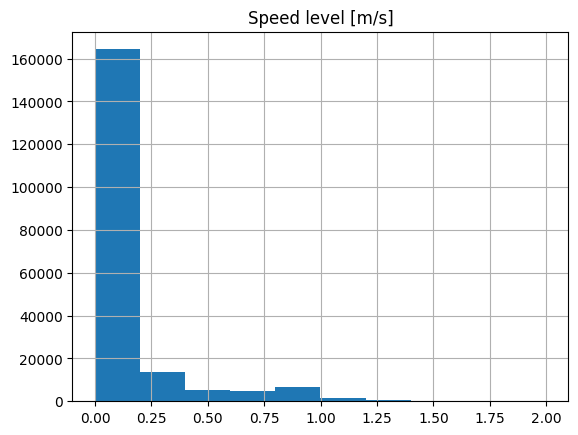

In [5]:
ax=df_results[df_results["distance(m)"]<2]["distance(m)"].hist()
ax.set_title("Speed level [m/s]")

In [6]:
df_key_param = df_results[df_results.meas_running].reset_index()\
        .groupby('corresponding_meas_file')\
            .agg(start=('datetime_AMT', 'min'),
                 end=('datetime_AMT', 'max'),
                 experiment_location = ('experiment_location', 'first'),
                 position = ('position', 'first'),
                 lat_est_mean=('lat_est', 'mean'),
                 lon_est_mean=('lon_est', 'mean'),
                 hdop_max=('hdop', 'max'),
                 nsats_min=('nsats', 'min'),
                 CO2_min=('CO2(ppm)', 'min'),
                 CO2_max=('CO2(ppm)', 'max'),
                 humidity_in_mean=('humidity in(rH)', 'mean'),
                 humidity_out_mean=('humidity out(rH)', 'mean'),
                 airtemp_in_mean=('airtemp in(degreeC)', 'mean'),
                 PAR_min=('PAR(umol m-2s-1)', 'min'),
                 PAR_max=('PAR(umol m-2s-1)', 'max'),
                 airtemp_out_mean=('airtemp out(degreeC)', 'mean'))

result_file = output_data_folder / Path(key_parameter_file_name) 
print(f"    ... saving to \n        {result_file}")
df_key_param.to_pickle(result_file)

    ... saving to 
        /home/sebastian/Nextcloud/Projekte/2021_DAAD_Brasilien/2023/RoBiMo_Trop_DataSet/notebooks/../results/key_parameter_2023.p
